# 1. Data Exploration

Download the data from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [27]:
import pandas as pd
data = pd.read_csv('train.csv')
print('Shape of the data: ', data.shape)
data.head()

Shape of the data:  (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [28]:
y_cols = list(data.columns[2:])
is_multilabel = (data[y_cols].sum(axis=1) >1).count()
print('is_multilabel count: ', is_multilabel)

is_multilabel count:  159571


 - From the above data we can see that not all comments have title.
 - Its Multilabel data (every comment can have more than one label)
 - Add a label, 'non_toxic' for comments with no label

In [29]:
data['non_toxic'] = 1-data[y_cols].max(axis=1)
y_cols += ['non_toxic']

In [30]:
def get_class_weight(data):
    class_weight = {}
    for num,col in enumerate(y_cols):
        if num not in class_weight:
            class_weight[col] = round((data[data[col] == 1][col].sum())/data.shape[0]*100,2)
    return class_weight
class_weight = get_class_weight(data)
print('Total class weight: ', sum(class_weight.values()), '%\n\n', class_weight)

Total class weight:  111.82 %

 {'toxic': 9.58, 'severe_toxic': 1.0, 'obscene': 5.29, 'threat': 0.3, 'insult': 4.94, 'identity_hate': 0.88, 'non_toxic': 89.83}


# 2. Split data into train, test, validation

In [31]:
from sklearn.model_selection import train_test_split
def get_train_test_val(data):
    X_data = data['comment_text'].values
    y_data = data[list(data.columns[2:])].values
    X, X_test, y, y_test = train_test_split(X_data, y_data, test_size=0.1, train_size=0.9)
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.25,train_size =0.75)

    print(
        'X_train shape', X_train.shape,
        '\ny_train shape', y_train.shape,
        '\nX_test shape', X_test.shape,
        '\ny_test shape', y_test.shape,
        '\nX_val shape', X_val.shape,
        '\ny_val shape', y_val.shape,

    )
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_val(data)

X_train shape (107709,) 
y_train shape (107709, 7) 
X_test shape (15958,) 
y_test shape (15958, 7) 
X_val shape (35904,) 
y_val shape (35904, 7)


In [7]:
X_train[0]

"'m fortunate I revisited the page or I might not have noticed you turned information I researched and posted into a BLANK.  I"

# 3. Text preprocessing

In [8]:
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/snehalnair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/snehalnair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.replace('\n', ' ').lower()# lowercase text
    text = REPLACE_IP_ADDRESS.sub('', text) # remove ip address
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([w for w in text.split() if not w in STOPWORDS])# delete stopwords from text
    return text

X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_train[:1]

['thanks much assistance input']

# BoW (Bag of Words)

In [36]:
from scipy import sparse as sp_sparse

In [49]:
# Dictionary of all words from train corpus with their counts.
words_counts = {}
for comments in X_train:
    for word in comments.split():
        if word not in words_counts:
            words_counts[word] = 1
        words_counts[word] += 1
        
DICT_SIZE = 10000
POPULAR_WORDS = sorted(words_counts, key=words_counts.get, reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {key: rank for rank, key in enumerate(POPULAR_WORDS, 0)}
INDEX_TO_WORDS = {index:word for word, index in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

In [50]:
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split(' '):
        if word in words_to_index:
            result_vector[words_to_index[word]] +=1
    return result_vector

X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
print('X_train shape ', X_train_mybag.shape, '\nX_val shape ', X_val_mybag.shape)

X_train shape  (107709, 10000) 
X_val shape  (35904, 10000)


In [51]:
POPULAR_WORDS[:10]

['article',
 'page',
 'wikipedia',
 'talk',
 'please',
 'would',
 'one',
 'like',
 'dont',
 'see']

# TF-IDF

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [53]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)#, token_pattern='(\S+)')
    # Fit the vectorizer on the train set
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    # Transform the train, test set and return the result
    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vectorizer.vocabulary_

X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

# Classification

In [73]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def train_classifier(X_train, y_train, C, regularisation):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    
    # Create and fit LogisticRegression wraped into OneVsRestClassifier.

    model = OneVsRestClassifier(LogisticRegression(penalty=regularisation, C=C, max_iter=10000)).fit(X_train, y_train)
    return model

classifier_mybag = train_classifier(X_train_mybag, y_train, C = 4, regularisation = 'l2')
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C = 4, regularisation = 'l2')

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)

In [70]:
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Text(69.0, 0.5, 'Actual_mybag')

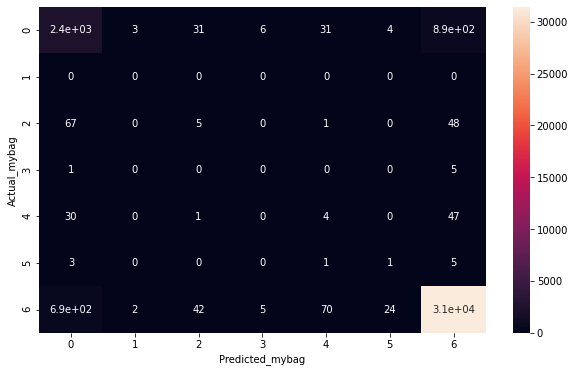

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(
    y_val.argmax(axis=1), y_val_predicted_labels_mybag.argmax(axis=1))

import seaborn as sns
plt.subplots(figsize=(10,6))
sns.heatmap(confusion_mat, annot=True)
plt.xlabel('Predicted_mybag')
plt.ylabel('Actual_mybag')

# Evaluation

In [63]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [74]:
classifier_mybag = train_classifier(X_train_mybag, y_train, C = 50, regularisation = 'l2')
classifier_tfidf = train_classifier(X_train_tfidf, y_train, C = 50, regularisation = 'l2')

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy: ', accuracy_score(y_test, predicted, normalize=False))
    print('F1-score macro: ', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro: ', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted: ', f1_score(y_test, predicted, average='weighted'))
    print('Precision macro: ', average_precision_score(y_test, predicted, average='macro'))
    print('Precision micro: ', average_precision_score(y_test, predicted, average='micro'))
    print('Precision weighted: ', average_precision_score(y_test, predicted, average='weighted'))
    
print('Bag-of-words\n')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('\nTfidf\n')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words

Accuracy:  31478
F1-score macro:  0.5566628753298849
F1-score micro:  0.9032797106871181
F1-score weighted:  0.9021051079960551
Precision macro:  0.381767138744852
Precision micro:  0.8318290436395079
Precision weighted:  0.861069058293876

Tfidf

Accuracy:  32795
F1-score macro:  0.6194098323186851
F1-score micro:  0.9279700654817586
F1-score weighted:  0.9207121713246827
Precision macro:  0.4562168575482601
Precision micro:  0.8753395290074283
Precision weighted:  0.8787874512157651


### Get prediction labels

In [129]:
test_predictions = classifier_tfidf.predict(X_test_tfidf)

In [137]:
def get_pred_labels(data, predictions):
    y_cols = list(data.columns[2:])
    y_label_dict={}
    for k,v in enumerate(y_cols):
        y_label_dict[k] = v

    test_predictions_labels = []
    for pred in predictions:
        label_pred = []
        for index, label in enumerate(list(pred)):
            if label != 0:
                label = y_label_dict[index]
            label_pred.append(label)
        test_predictions_labels.append(tuple([i for i in label_pred if i != 0]))
    return test_predictions_labels

test_pred_labels = get_pred_labels(data, test_predictions)
test_labels = get_pred_labels(data, y_test)

In [155]:
for i in range(90,97):
    print('\ny_label: ', test_labels[i], '\ny_pred: ', test_pred_labels[i])


y_label:  ('toxic', 'obscene', 'insult', 'identity_hate') 
y_pred:  ('toxic', 'obscene', 'insult', 'identity_hate')

y_label:  ('toxic', 'severe_toxic', 'obscene', 'insult') 
y_pred:  ('toxic', 'obscene')

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('non_toxic',)

y_label:  ('non_toxic',) 
y_pred:  ('toxic',)


In [134]:
len(test_predictions_labels)

15958

## WordCloud

/Users/snehalnair/Workspace/blog/image_processing/imageenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


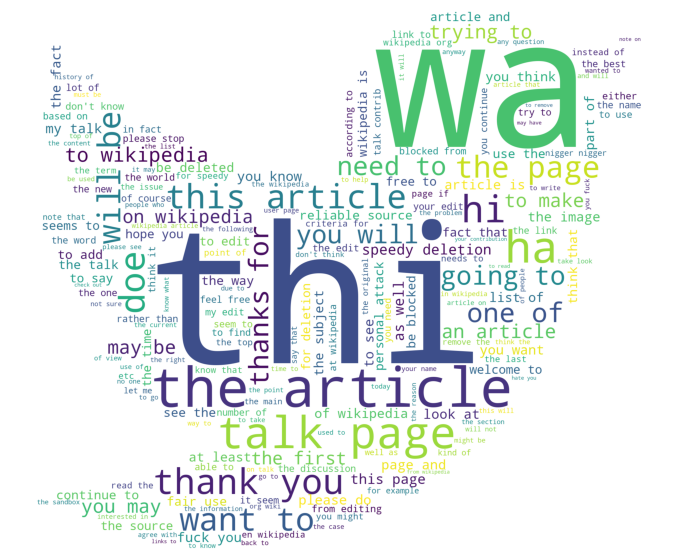

In [62]:
comments_join = ' '.join(POPULAR_WORDS)

from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS 


twitter_mask = imread('twitter.png', flatten=True)
    
wordcloud = WordCloud(
                      stopwords=STOPWORDS,
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=twitter_mask
            ).generate(comments_join)

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('twitter_comments.png', dpi=300)
plt.show()

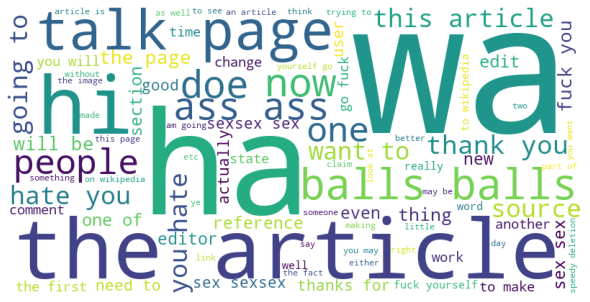

In [157]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 


df = data[:10000]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.comment_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

wordcloud.to_file('wordcloud.png')
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 